# Step 1: Import Essential Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

Mounted at /content/drive


# Step 2: Prepare Dataset and Hardware

In [ ]:
# Set project and dataset paths
PROJECT_PATH = "/content/drive/My Drive/BME230A_Project"
TRAIN_DIR = "/content/drive/My Drive/BME230A_Project/Dataset/Train"
TEST_DIR = "/content/drive/My Drive/BME230A_Project/Dataset/Test"

In [ ]:
# Funciton to count images per class
def count_images_per_class(directory):
    class_names = []
    image_counts = []
    print(f"\n📂 Checking images in: {directory}\n")
    for class_folder in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            num_images = len([img for img in os.listdir(class_path) if img.endswith(".jpg")])
            class_names.append(class_folder)
            image_counts.append(num_images)
            print(f"📂 {class_folder}: {num_images} images")
    return class_names, image_counts

train_classes, train_counts = count_images_per_class(TRAIN_DIR)
test_classes, test_counts = count_images_per_class(TEST_DIR)


📂 Checking images in: /content/drive/My Drive/BME230A_Project/Dataset/Train

📂 actinic keratosis: 304 images
📂 basal cell carcinoma: 492 images
📂 dermatofibroma: 113 images
📂 melanoma: 955 images
📂 nevus: 5633 images
📂 pigmented benign keratosis: 994 images
📂 seborrheic keratosis: 77 images
📂 squamous cell carcinoma: 181 images
📂 vascular lesion: 141 images

📂 Checking images in: /content/drive/My Drive/BME230A_Project/Dataset/Test

📂 actinic keratosis: 55 images
📂 basal cell carcinoma: 98 images
📂 dermatofibroma: 23 images
📂 melanoma: 158 images
📂 nevus: 1072 images
📂 pigmented benign keratosis: 202 images
📂 seborrheic keratosis: 3 images
📂 squamous cell carcinoma: 16 images
📂 vascular lesion: 20 images


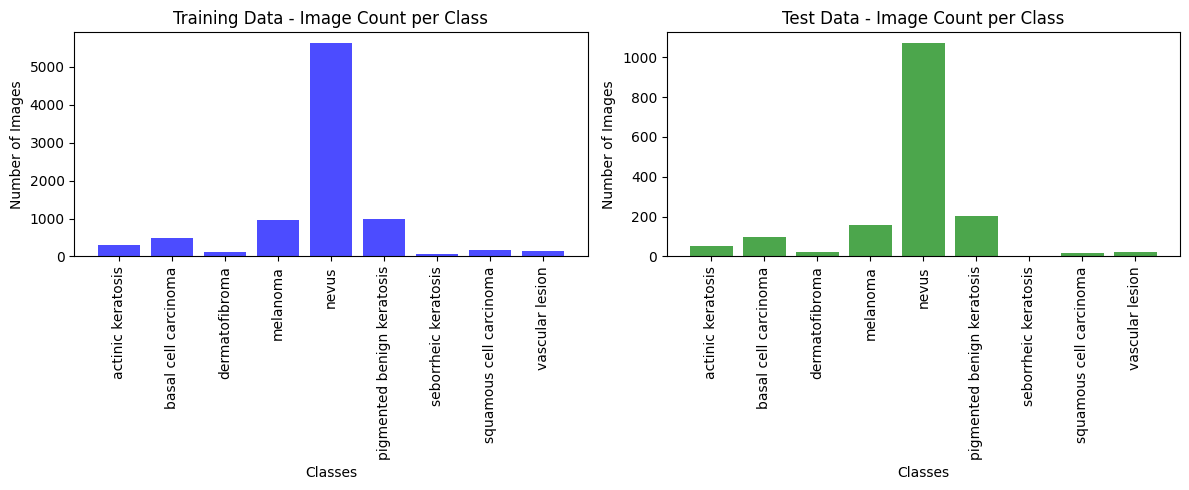

In [ ]:
# Visualize image distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(train_classes, train_counts, color='blue', alpha=0.7)
ax[0].set_title("Training Data - Image Count per Class")
ax[0].set_ylabel("Number of Images")
ax[0].set_xlabel("Classes")
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(test_classes, test_counts, color='green', alpha=0.7)
ax[1].set_title("Test Data - Image Count per Class")
ax[1].set_ylabel("Number of Images")
ax[1].set_xlabel("Classes")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Use TPU strategy
    print("✅ TPU detected and initialized!")
except ValueError:
    strategy = tf.distribute.get_strategy()  # Fallback to CPU/GPU
    print("🔴 TPU not found, using CPU/GPU.")

🔴 TPU not found, using CPU/GPU.


# Step 3: Preprocessing and Data Augmentation

In [ ]:
# Define a data augmentation pipeline.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.0556),  # ~20° rotation
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2)
])

def preprocess_train(image, label):
    image = tf.cast(image, tf.float32)  # ensure float32
    image = data_augmentation(image, training=True)
    image = tf.clip_by_value(image, 0, 255)  # clip values to valid range
    image = preprocess_input(image)
    return image, label

# Create the test dataset with only rescaling.
def preprocess_test(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = preprocess_input(image)
    #image = image / 255.0
    return image, label

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

# Create the training dataset.
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_dataset.class_names

# Apply data augmentation to the training dataset.
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=AUTO)

#Shuffle, repeat, cache, and prefetch
train_dataset = train_dataset.shuffle(1000).repeat().cache().prefetch(AUTO)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
).map(preprocess_test, num_parallel_calls=AUTO).cache().prefetch(AUTO)

# Calculate steps_per_epoch using the total number of training samples.
def count_images(directory):
    total = 0
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            total += len([img for img in os.listdir(folder_path) if img.lower().endswith('.jpg')])
    return total

total_train_samples = count_images(TRAIN_DIR)
steps_per_epoch = math.ceil(total_train_samples / BATCH_SIZE)
print(f"Total training samples: {total_train_samples}")
print(f"Steps per epoch: {steps_per_epoch}")

Found 8890 files belonging to 9 classes.
Found 1647 files belonging to 9 classes.
Total training samples: 8890
Steps per epoch: 139


# Step 4: Define the CNN Model using ResNet50

In [ ]:
# Enable mixed precision for faster training on TPU, which might introduce stabilities.
tf.keras.mixed_precision.set_global_policy("mixed_float16") # For GPU/CPU

NUM_CLASSES = 9  # Update as needed for your dataset

def create_model():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # Freeze all layers except the last 10 layers for fine-tuning.
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    x = GlobalAveragePooling2D(name='gap')(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    # The final layer uses dtype="float32" to ensure proper numeric precision.
    predictions = Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy",
                            tf.keras.metrics.AUC(name='roc_auc'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

# Create and compile the model within the TPU strategy scope.
with strategy.scope():
    base_optimizer = Adam(learning_rate=0.0005)
    optimizer = LossScaleOptimizer(base_optimizer, dynamic=True)
    model = create_model()
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy",
                           tf.keras.metrics.AUC(name='roc_auc'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    model = create_model() # Commented Out, works with CPU/GPU

model.summary()
print("✅ CNN Model (ResNet50) is ready for training!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ cast_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,770,441 (94.49 MB)

 Trainable params: 5,648,393 (21.55 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

✅ CNN Model (ResNet50) is ready for training!


# Step 5: Train the Model

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,  # Adjust the number of epochs as needed.
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ]
)

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 324s 413ms/step - accuracy: 0.6601 - loss: 1.0806 - precision: 0.7930 - recall: 0.5503 - roc_auc: 0.9204 - val_accuracy: 0.7583 - val_loss: 0.8455 - val_precision: 0.8038 - val_recall: 0.7213 - val_roc_auc: 0.9573
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 263ms/step - accuracy: 0.7518 - loss: 0.7176 - precision: 0.8444 - recall: 0.6702 - roc_auc: 0.9664 - val_accuracy: 0.7699 - val_loss: 0.7245 - val_precision: 0.8283 - val_recall: 0.7146 - val_roc_auc: 0.9666
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 35s 254ms/step - accuracy: 0.7753 - loss: 0.6320 - precision: 0.8486 - recall: 0.7078 - roc_auc: 0.9739 - val_accuracy: 0.8057 - val_loss: 0.6161 - val_precision: 0.8452 - val_recall: 0.7723 - val_roc_auc: 0.9754
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 33s 240ms/step - accuracy: 0.8036 - loss: 0.5486 - precision: 0.8662 - recall: 0.7489 - roc_auc: 0.9798 - val_accuracy: 0.7541 - val_loss: 0.7708 - val_precision: 0.7900 - val_recall: 0.7262 - val_roc

# Step 6: Visualize and Plot Metrics

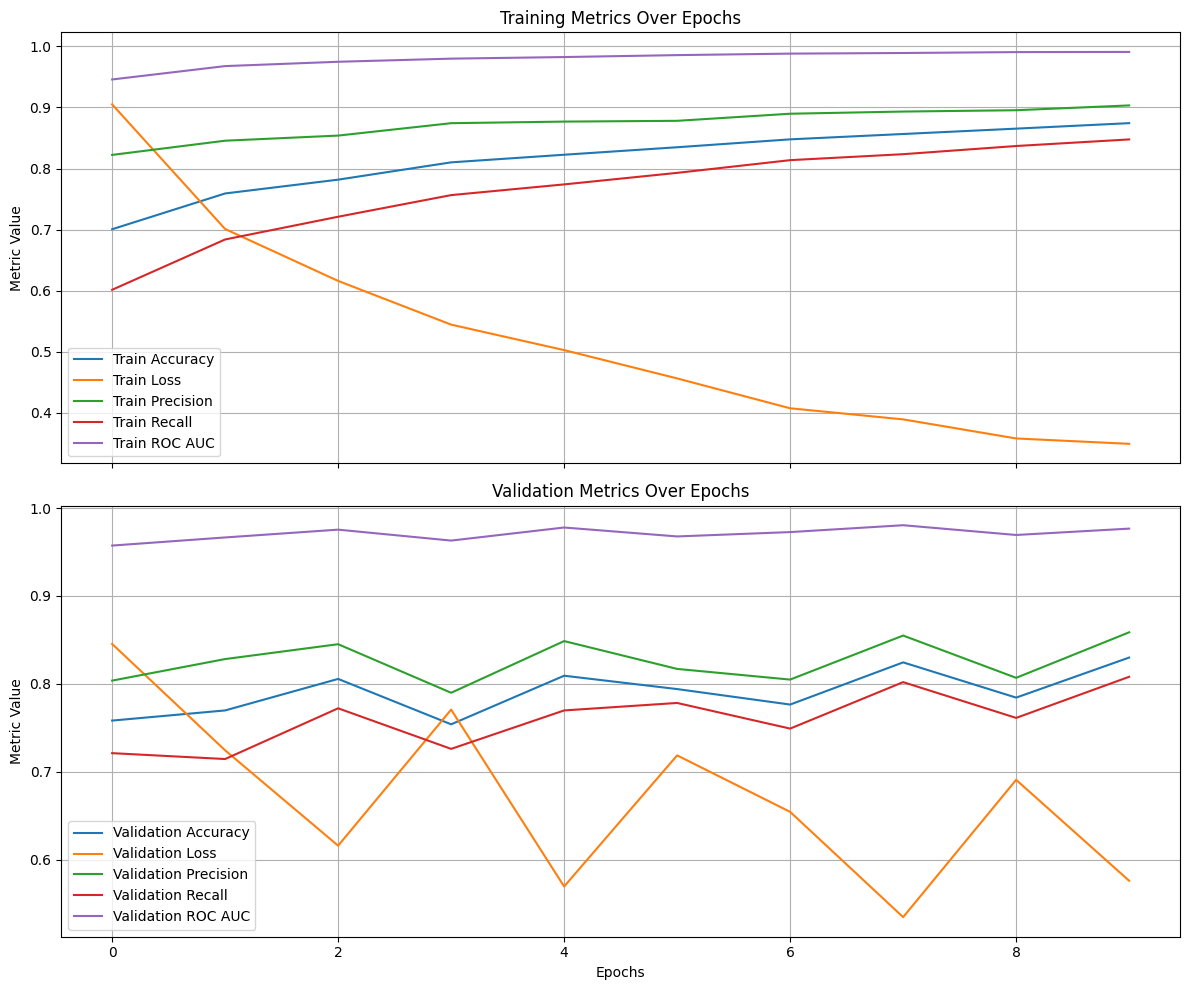

In [ ]:
# Create a figure with two subplots (one for training, one for validation)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)


# ----- Plot Training Metrics -----
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['precision'], label='Train Precision')
ax1.plot(history.history['recall'], label='Train Recall')
ax1.plot(history.history['roc_auc'], label='Train ROC AUC')
ax1.set_ylabel("Metric Value")
ax1.set_title("Training Metrics Over Epochs")
ax1.legend()
ax1.grid(True)

# ----- Plot Validation Metrics -----
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.plot(history.history['val_precision'], label='Validation Precision')
ax2.plot(history.history['val_recall'], label='Validation Recall')
ax2.plot(history.history['val_roc_auc'], label='Validation ROC AUC')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Metric Value")
ax2.set_title("Validation Metrics Over Epochs")
ax2.legend()
ax2.grid(True)

plt.tight_layout()  # Adjusts subplot params for a neat layout
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step


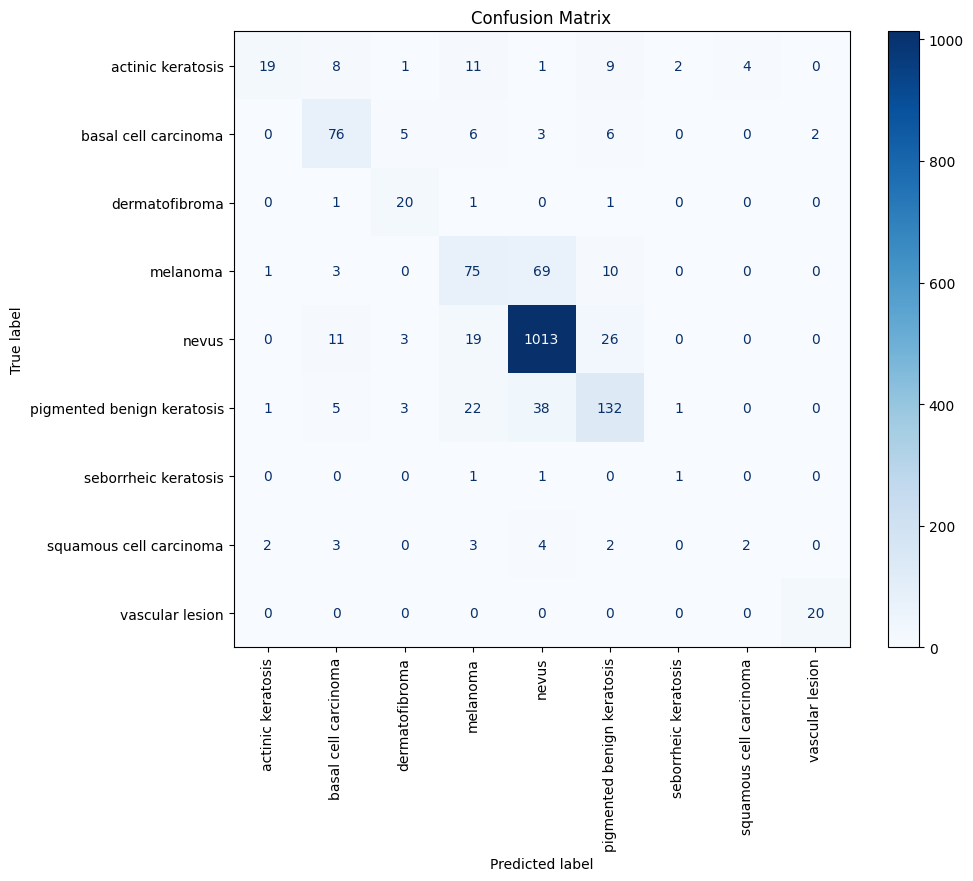

In [ ]:
import numpy as np

# ============
# Step 1: Get True Labels and Predictions from Test Dataset
# ============
# Since test_dataset is a tf.data.Dataset, we extract the labels and predictions
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)
y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# ============
# Step 2: Confusion Matrix
# ============
# Compute the confusion matrix using scikit-learn
cm = confusion_matrix(y_true_labels, y_pred_labels)
# Use the class names from your training data for display labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_classes)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_xticklabels(disp.display_labels, rotation=90)  # Make x labels vertical
plt.title('Confusion Matrix')
plt.show()

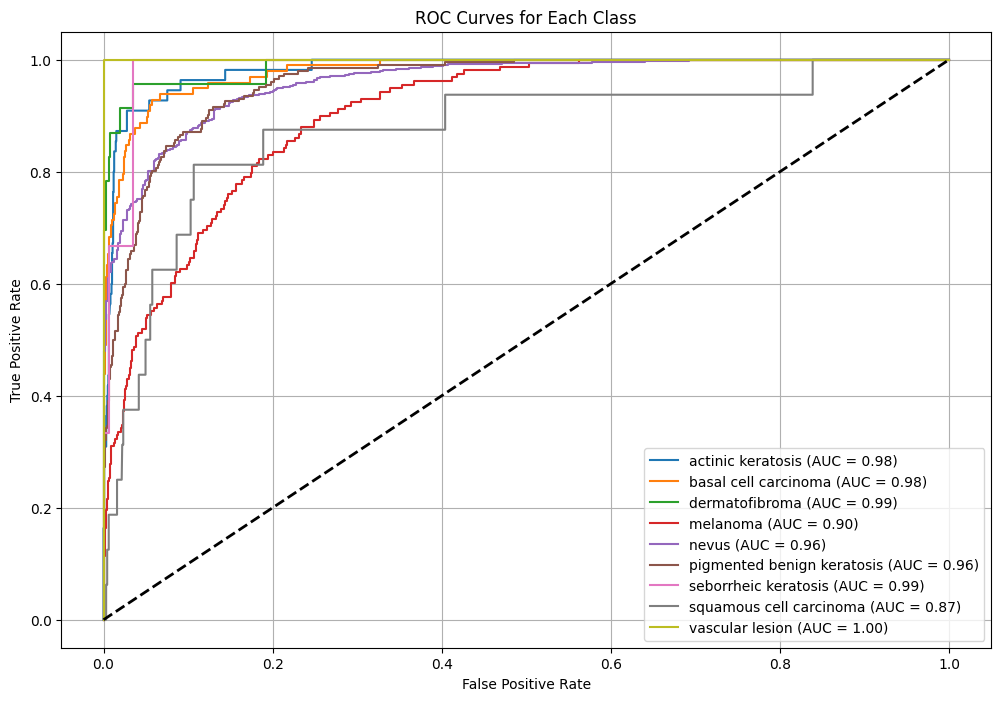

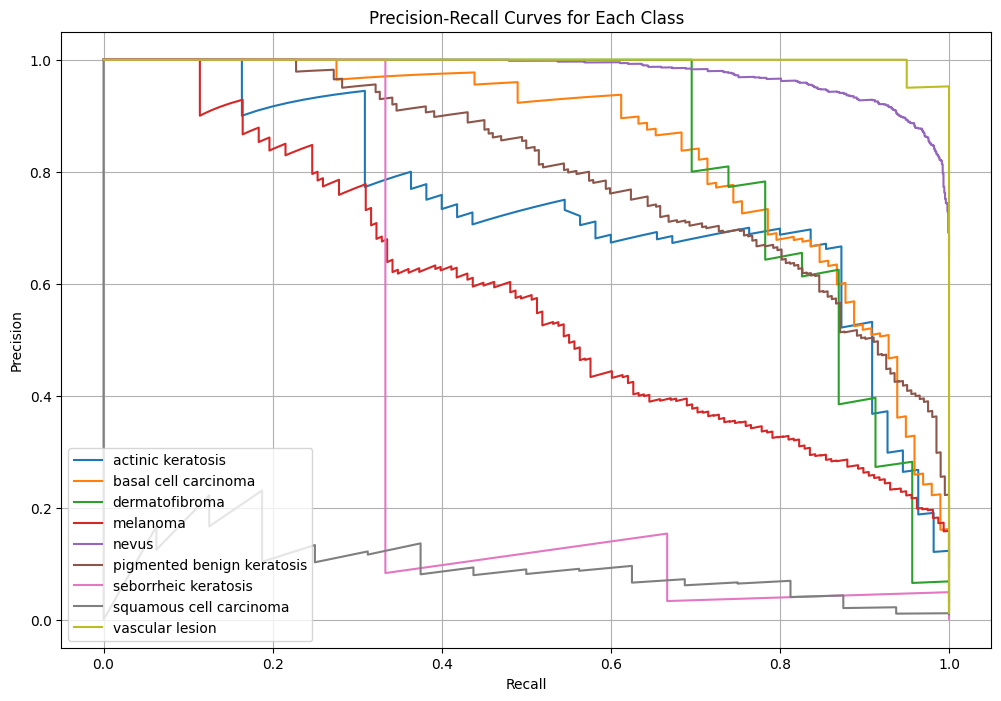

In [ ]:
# ============
# Step 3: ROC Curves and Precision-Recall Curves for Each Class
# ============
# For multiclass ROC and PR curves, binarize the true labels (one-vs-all)
n_classes = NUM_CLASSES
y_true_bin = label_binarize(y_true_labels, classes=list(range(n_classes)))

# ----- ROC Curves -----
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{train_classes[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ----- Precision-Recall Curves -----
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall_vals, precision_vals, label=f'{train_classes[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step


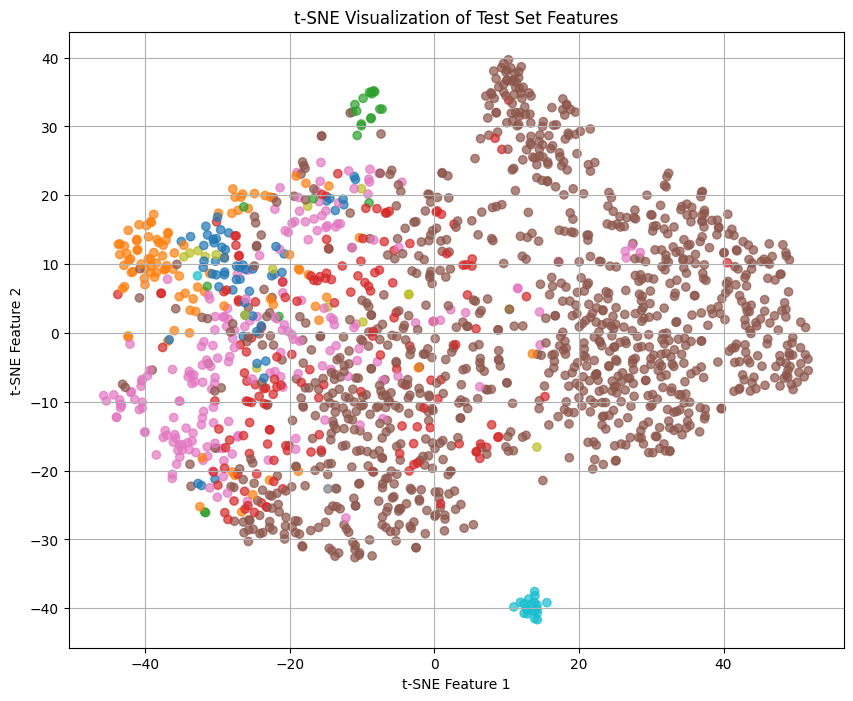

In [ ]:
# ============
# Step 4: Feature Space Visualization using t-SNE
# ============

feature_extractor = Model(inputs=model.input, outputs=model.get_layer('gap').output)
# Extract features for all images in the test dataset
features = feature_extractor.predict(test_dataset)

# Use t-SNE to reduce dimensionality of features to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
# Scatter plot: color by true label
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_true_labels, cmap='tab10', alpha=0.7)
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Visualization of Test Set Features')
# Create a legend using the train_classes (assumed sorted consistently with your dataset)
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=train_classes, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(legend1)
plt.grid(True)
plt.show()

In [ ]:
X_test = []
y_test = []
for images, labels in test_dataset:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot to integer labels


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step


In [ ]:
import cv2
import seaborn as sns
import collections
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
def grad_cam(model, image, class_idx, layer_name="conv5_block3_out"):
    """
    Applies Grad-CAM to visualize important regions in an image.
    Adjust 'layer_name' to a convolutional layer that exists in your model.
    """
    img_array = np.expand_dims(image, axis=0)

    # Create a model that outputs the activations of the target layer and predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Compute gradients of the loss with respect to the convolutional output.
    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Compute the heatmap.
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output[0]), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)

    # Avoid division by zero: if the max is zero, return an array of zeros.
    max_val = np.max(heatmap)
    if max_val == 0:
        heatmap = np.zeros_like(heatmap)
    else:
        heatmap /= max_val

    return heatmap

# Choose an example test image.
image_idx = 5  # Adjust index as needed.
test_image = X_test[image_idx]
true_label = y_test_labels[image_idx]
pred_label = y_pred[image_idx]

# # Compute the heatmap using Grad-CAM.
# heatmap = grad_cam(model, test_image, pred_label, layer_name="conv5_block3_out")
# print("Heatmap shape:", heatmap.shape)  # Should be (H, W), e.g., (7, 7)

# # Resize and colorize the heatmap.
# heatmap_resized = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]))
# heatmap_resized = np.uint8(255 * heatmap_resized)
# heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Ensure heatmap is contiguous and has type float32.
heatmap = np.ascontiguousarray(heatmap, dtype=np.float32)

# Explicitly set the interpolation method.
heatmap_resized = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]), interpolation=cv2.INTER_LINEAR)

# Continue with color mapping and overlay.
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Convert test_image to uint8 if necessary.
test_image_uint8 = test_image.astype(np.uint8) if test_image.dtype != np.uint8 else test_image

# Overlay the heatmap on the original image.
overlayed = cv2.addWeighted(test_image_uint8, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Grad-CAM Visualization\nTrue Label: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
plt.show()

In [ ]:

# ----------------------------
# 8. Additional Evaluations
# ----------------------------
# (a) Plot histogram of confidence scores for a chosen class if binary.
if NUM_CLASSES == 9:
    plt.figure(figsize=(6,6))
    plt.hist(y_pred_probs[:,1], bins=20, color='blue', alpha=0.6, edgecolor='black')
    plt.xlabel("Prediction Confidence (Class 1)")
    plt.ylabel("Count")
    plt.title("Confidence Score Distribution")
    plt.show()


                            precision    recall  f1-score   support

         actinic keratosis       0.83      0.35      0.49        55
      basal cell carcinoma       0.71      0.78      0.74        98
            dermatofibroma       0.62      0.87      0.73        23
                  melanoma       0.54      0.47      0.51       158
                     nevus       0.90      0.94      0.92      1072
pigmented benign keratosis       0.71      0.65      0.68       202
      seborrheic keratosis       0.25      0.33      0.29         3
   squamous cell carcinoma       0.33      0.12      0.18        16
           vascular lesion       0.91      1.00      0.95        20

                  accuracy                           0.82      1647
                 macro avg       0.64      0.61      0.61      1647
              weighted avg       0.82      0.82      0.82      1647



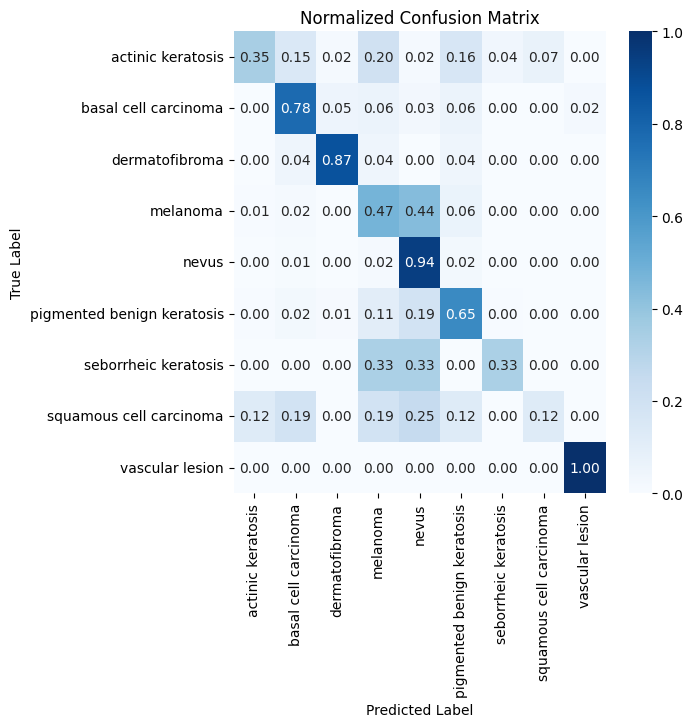

In [ ]:
# (b) Confusion matrix and classification report.
cm = confusion_matrix(y_test_labels, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(classification_report(y_test_labels, y_pred, target_names=class_names))

plt.figure(figsize=(6,6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()